In [3]:
import Trial_Processing as pts
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
# Load the List of data files, this contains references to all the data files as well as mouse name and date information
data_files = pd.read_csv('../output_reference_list.csv', header=0)

In [20]:
# Load the first file into a photometry data object
test_experiment = pts.PhotometryVideoData(data_files['path'][1], trim_start=12)

/home/murph_4090ws/Documents/Social_Interaction_Analysis/src/Trial_Processing.py:306: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(photo_csv_path)


## PhotometryVideoData Object
This is the main object used for handling the photometry data, it can load data using ```get_photometry_data(trial)``` which lets you get 1 trial period of data, in addition you can also use ```get_all_photometry_data``` to get all the data in an array, as it returns a dict you can get each individual channel through keying with the channel name (405A, 405C, 465A, 465C)

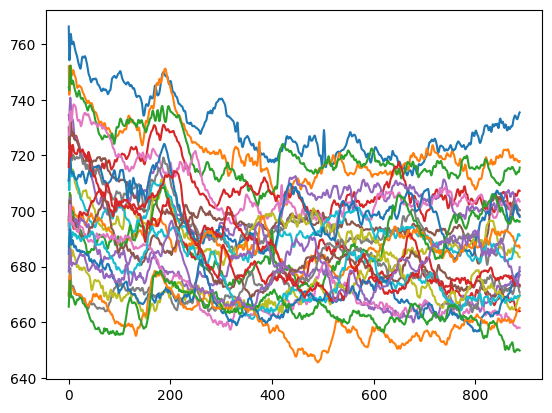

In [21]:
for i in range(25):
    plt.plot(test_experiment.get_photometry_data(i + 1)['465C'])
plt.show()